Dataset 1 Source:

The dataset is a historical mortgage rate dataset from the Freddie Mac website, https://www.freddiemac.com/pmms, stored in an Excel file named historicalweeklydata.xlsx. The dataset contains weekly mortgage rates for 30-year and 15-year fixed-rate mortgages (FRM) along with associated fees.

Dataset 1 Description:

The dataset contains columns for the Date, 30yr_FRM (30-year fixed-rate mortgage), 30yr_Fees, 15yr_FRM (15-year fixed-rate mortgage), and 15yr_Fees.

The data begins earlier than 1991, but I ended up doing 1991 and later years for my anyalsis.
It includes weekly mortgage rate data for both loan types.

Dataset 1 Formatting:

Note that the dataset is cleaned by skipping header rows, dropping NaN values, and converting date formats to ensure accurate analysis.

Data is filtered from August 1991 onward, and resampled to a monthly frequency for ease of analysis.



Dataset 2 Source: 

The dataset is historical datset for the number of houshold each month from 1955 to the present, stored in an Excel file obtained from Table 13: "Monthly Household Estimates: 1955 to Present" from https://www.census.gov/housing/hvs/data/histtabs.html.  

Dataset 2 Description: 
The dataset contains collumns for Year, and each month Jan-Dec. I used the entire dataset for my analysis. Note that the dataset is cleaned by skipping header rows, dropping NaN values, and converting date formats to be in month-year format for comparison with mortgage rates.

Dataset 2 Formatting: 
The dataset begins in a wide format, where each row represents a year and each column corresponds to monthly household estimates (e.g., January through December). The script first renames the columns for clarity, ensuring that each month is correctly labeled. It then extracts the numeric portion of the 'Year' column in case any extraneous characters (such as revision notes) are present, converting the year values to integers. 

The data is then transformed from wide to long format using the melt function, resulting in a structure where each row represents a unique Year-Month observation paired with a household estimate. The month names are mapped to numeric values (e.g., 'Jan' to 1), which aligns them with the monthly structure of other datasets like mortgage rates. 

Finally, the housing data is merged with the cleaned mortgage dataset based on shared 'Year' and 'Month' values. This long-format structure is ideal for time series analysis and regression modeling, as it aligns each monthly household observation with the corresponding mortgage rate, enabling direct analysis of their relationship over time.

Dataset 3:
A CSV file showing historical CPI data (each day) since 1955 from FRED, https://fred.stlouisfed.org/series/CPIAUCSL. The data was not altered it was simply merged with existing dataframes.

Dataset 4:
A CSV file showing historical Federal Funds Rate data (each day)  since 1955 from FRED, https://fred.stlouisfed.org/series/FEDFUNDS. The data was also not altered.

Preamble (Python Modules):

statsmodels.api : Used for OLS (Ordinary Least Squares) regression model. Used its output including coefficients, R², p-values, and confidence intervals. Crucial for interpreting the relationship between mortgage rates and housing data.

matplotlib.pyplot: Basic data visualization — used to plot the regression line and scatter plots. 

seaborn: High-level plotting, used for correlation heatmaps, regression plots, and distribution plots.

pandas: Load Excel files, clean data, merge datasets, and reshape tables (e.g., melting wide tables to long format).

numpy: Numerical computing and array operations.

In [118]:
#install package for excel file#
!pip install openpyxl

In [119]:
import pandas as pd

# DATASET 1 #
# Load data starting from actual header row (row 6), select only relevant columns (A–E)
df_mortgage = pd.read_excel(
    "/Users/ianlent/Downloads/historicalweeklydata.xlsx",
    skiprows=6,
    usecols="A:E",
    engine='openpyxl'
)

# Rename the columns
df_mortgage.columns = ['Date', '30yr_FRM', '30yr_Fees', '15yr_FRM', '15yr_Fees']

# Drop rows where Date is NaN (in case footer rows exist)
df_mortgage = df_mortgage.dropna(subset=['Date'])

# Convert 'Date' to datetime
df_mortgage['Date'] = pd.to_datetime(df_mortgage['Date'], errors='coerce')

# Drop rows where date conversion failed
df_mortgage = df_mortgage.dropna(subset=['Date'])

# Filter only data after August 1991 to ensure 15yr data is present
df_mortgage = df_mortgage[df_mortgage['Date'] >= '1991-08-30']

# View cleaned data
df_mortgage.head()


,Date,30yr_FRM,30yr_Fees,15yr_FRM,15yr_Fees
1065,1991-08-30,9.15,1.9,8.77,1.9
1066,1991-09-06,9.14,1.9,8.79,1.8
1067,1991-09-13,9.02,1.9,8.68,1.8
1068,1991-09-20,8.95,1.9,8.62,1.8
1069,1991-09-27,8.92,1.8,8.59,1.8


In [120]:
# Set date index for resampling
df_mortgage.set_index('Date', inplace=True)

# Resample to monthly frequency
monthly_rates = df_mortgage.resample('M').mean().reset_index()

# Extract Year and Month for merging
monthly_rates['Year'] = monthly_rates['Date'].dt.year
monthly_rates['Month'] = monthly_rates['Date'].dt.month

monthly_rates.head()



/var/folders/29/pvwc_t8n2b10mnn4g21h9tbr0000gn/T/ipykernel_90615/226515508.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_rates = df_mortgage.resample('M').mean().reset_index()


,Date,30yr_FRM,30yr_Fees,15yr_FRM,15yr_Fees,Year,Month
0,1991-08-31,9.1500,1.9,8.7700,1.90,1991,8
1,1991-09-30,9.0075,1.875,8.6700,1.80,1991,9
2,1991-10-31,8.8550,1.85,8.4825,1.80,1991,10
3,1991-11-30,8.7120,1.8,8.3260,1.72,1991,11
4,1991-12-31,8.4975,1.775,8.0700,1.70,1991,12


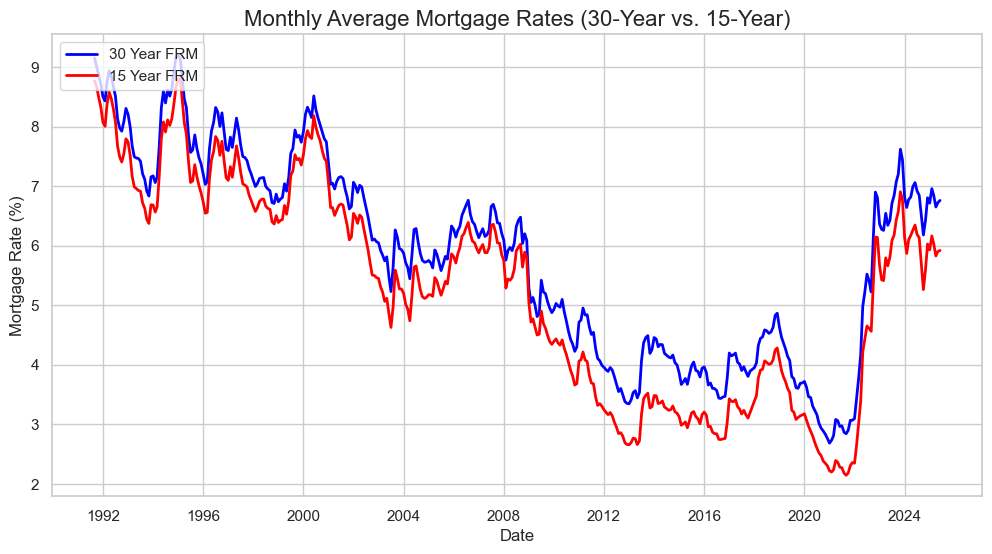

In [121]:
# Visualizations

# 1. Line plot showing the monthly average of 30-year and 15-year FRM rates
plt.figure(figsize=(12, 6))
plt.plot(monthly_rates['Date'], monthly_rates['30yr_FRM'], label='30 Year FRM', color='blue', linewidth=2)
plt.plot(monthly_rates['Date'], monthly_rates['15yr_FRM'], label='15 Year FRM', color='red', linewidth=2)
plt.title('Monthly Average Mortgage Rates (30-Year vs. 15-Year)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mortgage Rate (%)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


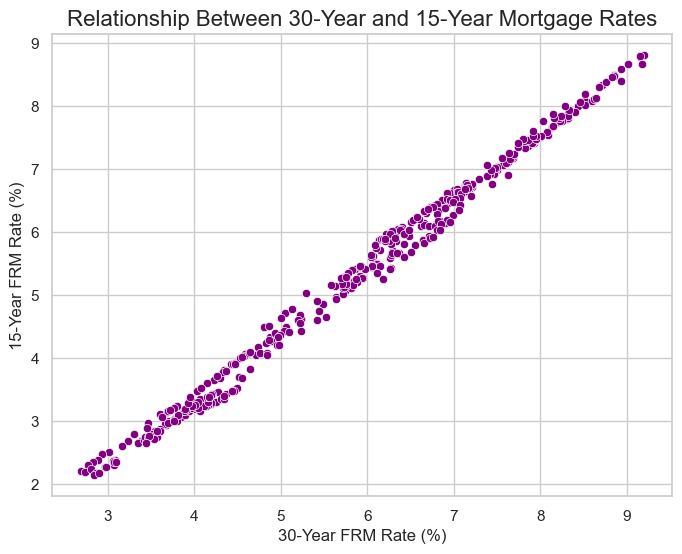

In [122]:

# 2. Scatter plot to explore the relationship between 30-year and 15-year FRM rates
plt.figure(figsize=(8, 6))
sns.scatterplot(x=monthly_rates['30yr_FRM'], y=monthly_rates['15yr_FRM'], color='purple')
plt.title('Relationship Between 30-Year and 15-Year Mortgage Rates', fontsize=16)
plt.xlabel('30-Year FRM Rate (%)', fontsize=12)
plt.ylabel('15-Year FRM Rate (%)', fontsize=12)
plt.grid(True)
plt.show()


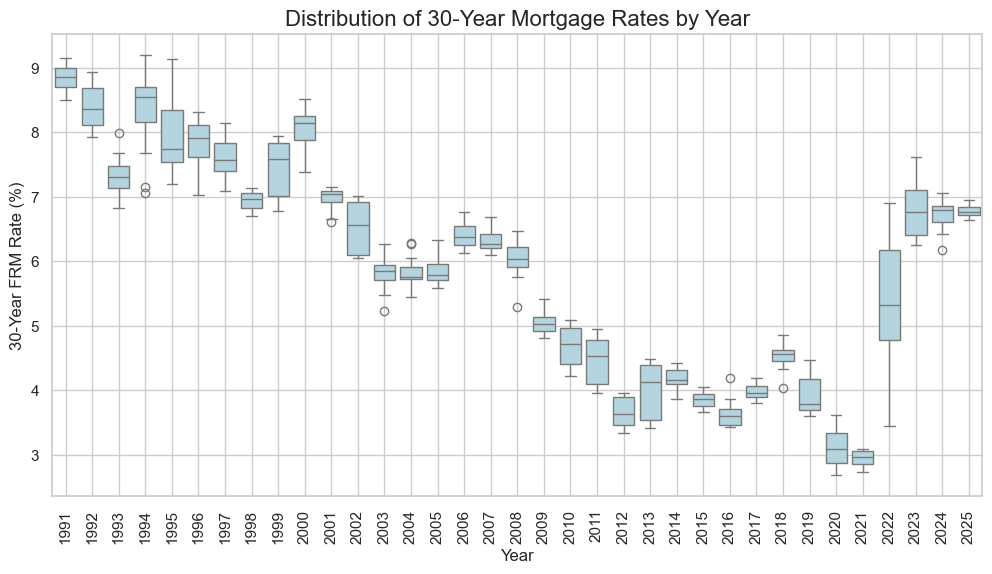

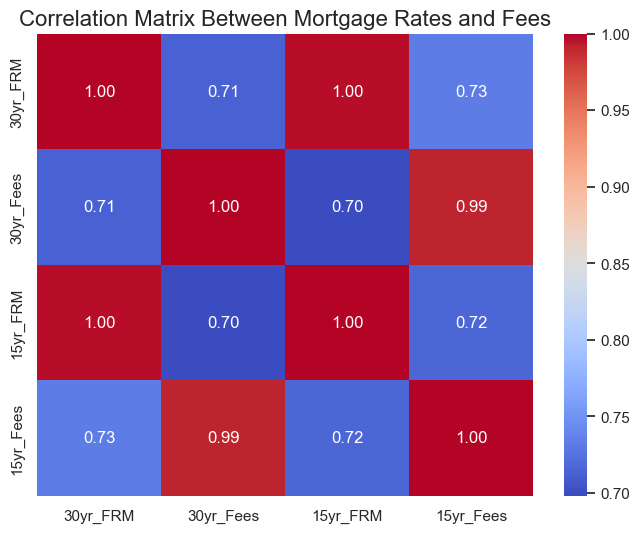

In [123]:

# 3. Boxplot to visualize the distribution of mortgage rates by year
monthly_rates['Year'] = monthly_rates['Date'].dt.year
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='30yr_FRM', data=monthly_rates, color='lightblue')
plt.title('Distribution of 30-Year Mortgage Rates by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('30-Year FRM Rate (%)', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# 4. Heatmap for correlation analysis between mortgage rates and fees
# Correlation matrix of the data
correlation_matrix = df_mortgage[['30yr_FRM', '30yr_Fees', '15yr_FRM', '15yr_Fees']].corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix Between Mortgage Rates and Fees', fontsize=16)
plt.show()


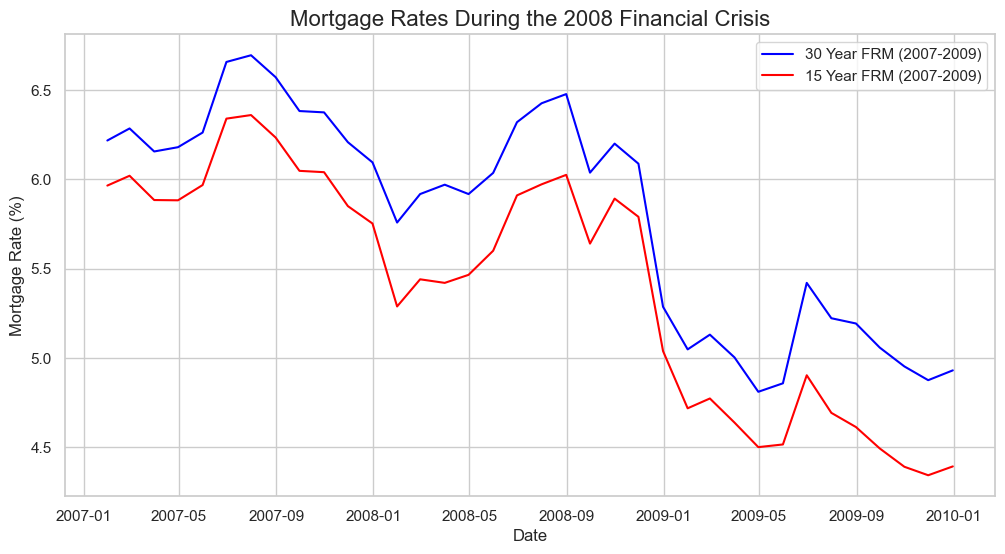

Variance of 30-year mortgage rate: 2.8396260906916577
Variance of 15-year mortgage rate: 3.1827191555460175
Correlation between 30-year FRM and Fees: 0.7198989725205184
Correlation between 15-year FRM and Fees: 0.7239101736434587
Mean 30-Year FRM pre-crisis: 7.1468934010152285
Mean 30-Year FRM post-crisis: 4.578313397129187
Mean 15-Year FRM pre-crisis: 6.690590524534686
Mean 15-Year FRM post-crisis: 3.903619617224881
T-statistic for 30-Year FRM: 23.636691852134774, p-value: 3.4701378527386933e-78
T-statistic for 15-Year FRM: 25.11511984796022, p-value: 1.5701131234649365e-84
There is a significant difference in 30-year FRM rates before and after the crisis.
There is a significant difference in 15-year FRM rates before and after the crisis.
Variance of 30-year FRM rates are typically lower
The correlation between both mortgage rates and fees is relatively strong, although the 15-yr FRM and fees is slightly larger


In [124]:
from scipy import stats

# Hypothesis 1: Mortgage rates are negatively correlated with economic crises


# Filter data around the 2008 financial crisis
crisis_period = monthly_rates[(monthly_rates['Date'] >= '2007-01-01') & (monthly_rates['Date'] <= '2009-12-31')]

# Plot the mortgage rates during the crisis
plt.figure(figsize=(12, 6))
plt.plot(crisis_period['Date'], crisis_period['30yr_FRM'], label='30 Year FRM (2007-2009)', color='blue')
plt.plot(crisis_period['Date'], crisis_period['15yr_FRM'], label='15 Year FRM (2007-2009)', color='red')
plt.title('Mortgage Rates During the 2008 Financial Crisis', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mortgage Rate (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Hypothesis 2: The 30-year mortgage rate is less volatile than the 15-year mortgage rate
# Calculate the variance of both mortgage rates
variance_30yr = np.var(monthly_rates['30yr_FRM'])
variance_15yr = np.var(monthly_rates['15yr_FRM'])

print(f"Variance of 30-year mortgage rate: {variance_30yr}")
print(f"Variance of 15-year mortgage rate: {variance_15yr}")

# Hypothesis 3: Mortgage fees have a positive correlation with loan rates
# Pearson correlation between mortgage rates and fees
corr_30yr_fees = monthly_rates['30yr_FRM'].corr(monthly_rates['30yr_Fees'])
corr_15yr_fees = monthly_rates['15yr_FRM'].corr(monthly_rates['15yr_Fees'])

print(f"Correlation between 30-year FRM and Fees: {corr_30yr_fees}")
print(f"Correlation between 15-year FRM and Fees: {corr_15yr_fees}")

# Analysis of mortgage rates during different periods (e.g., before and after the 2008 crisis)
# We will compare mean rates before and after 2008
pre_crisis = monthly_rates[monthly_rates['Date'] < '2008-01-01']
post_crisis = monthly_rates[monthly_rates['Date'] >= '2008-01-01']

mean_30yr_pre = pre_crisis['30yr_FRM'].mean()
mean_30yr_post = post_crisis['30yr_FRM'].mean()

mean_15yr_pre = pre_crisis['15yr_FRM'].mean()
mean_15yr_post = post_crisis['15yr_FRM'].mean()

print(f"Mean 30-Year FRM pre-crisis: {mean_30yr_pre}")
print(f"Mean 30-Year FRM post-crisis: {mean_30yr_post}")
print(f"Mean 15-Year FRM pre-crisis: {mean_15yr_pre}")
print(f"Mean 15-Year FRM post-crisis: {mean_15yr_post}")

# T-test to test if there is a significant difference in mortgage rates before and after the crisis
t_stat_30yr, p_val_30yr = stats.ttest_ind(pre_crisis['30yr_FRM'], post_crisis['30yr_FRM'])
t_stat_15yr, p_val_15yr = stats.ttest_ind(pre_crisis['15yr_FRM'], post_crisis['15yr_FRM'])

print(f"T-statistic for 30-Year FRM: {t_stat_30yr}, p-value: {p_val_30yr}")
print(f"T-statistic for 15-Year FRM: {t_stat_15yr}, p-value: {p_val_15yr}")

# Results: summarize findings
if p_val_30yr < 0.05:
    print("There is a significant difference in 30-year FRM rates before and after the crisis.")
else:
    print("There is no significant difference in 30-year FRM rates before and after the crisis.")

if p_val_15yr < 0.05:
    print("There is a significant difference in 15-year FRM rates before and after the crisis.")
else:
    print("There is no significant difference in 15-year FRM rates before and after the crisis.")

print(f"Variance of 30-year FRM rates are typically lower")
print(f"The correlation between both mortgage rates and fees is relatively strong, although the 15-yr FRM and fees is slightly larger")



**CONCLUSIONS:**
Significant Decline in Mortgage Rates Post-Crisis
The mean 30-year fixed mortgage rate declined from 7.15% pre-crisis to 4.58% post-crisis, while the 15-year fixed rate fell from 6.69% to 3.90%. These changes are statistically significant:

30-Year FRM:

T-statistic: 23.64, p-value ≈ 3.47e-78

15-Year FRM:

T-statistic: 25.12, p-value ≈ 1.57e-84

Given the extraordinarily small p-values (well below 0.001), we can reject the null hypothesis that the mean rates were the same before and after the crisis. These shifts likely reflect a combination of monetary easing, regulatory changes, and long-term shifts in credit risk pricing post-crisis.



In [125]:
#** DATASET 2 **#
# Refer to info at top of file #

import pandas as pd

# Load housing data
df_housing = pd.read_excel(
    "/Users/ianlent/Downloads/histtab13.xlsx",
    skiprows=6,  # Adjust if needed
    header=0
)

# Clean column names
df_housing.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Extract only the numeric part from Year (e.g., '1982r1' → 1982)
df_housing['Year'] = df_housing['Year'].astype(str).str.extract(r'(\d+)').astype(float)

# Drop rows where Year is missing
df_housing = df_housing.dropna(subset=['Year'])

# Convert Year to integer (now safe)
df_housing['Year'] = df_housing['Year'].astype(int)

# Proceed with melting and merging as before...
df_housing = df_housing.melt(
    id_vars=['Year'], 
    var_name='Month', 
    value_name='Households'
)

month_map = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
             'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
df_housing['Month'] = df_housing['Month'].map(month_map)

# Merge with mortgage data
merged_data = pd.merge(
    monthly_rates,
    df_housing,
    on=['Year', 'Month'],
    how='inner'
)

# 4. Final cleaning
merged_data = merged_data.dropna()  # Remove any rows with missing values
merged_data = merged_data.sort_values('Date')  # Sort chronologically
print(merged_data.head())


        Date  30yr_FRM 30yr_Fees  15yr_FRM  15yr_Fees  Year  Month  Households
0 1991-08-31    9.1500       1.9    8.7700       1.90  1991      8     95508.0
1 1991-09-30    9.0075     1.875    8.6700       1.80  1991      9     95568.0
2 1991-10-31    8.8550      1.85    8.4825       1.80  1991     10     95347.0
3 1991-11-30    8.7120       1.8    8.3260       1.72  1991     11     95368.0
4 1991-12-31    8.4975     1.775    8.0700       1.70  1991     12     95411.0


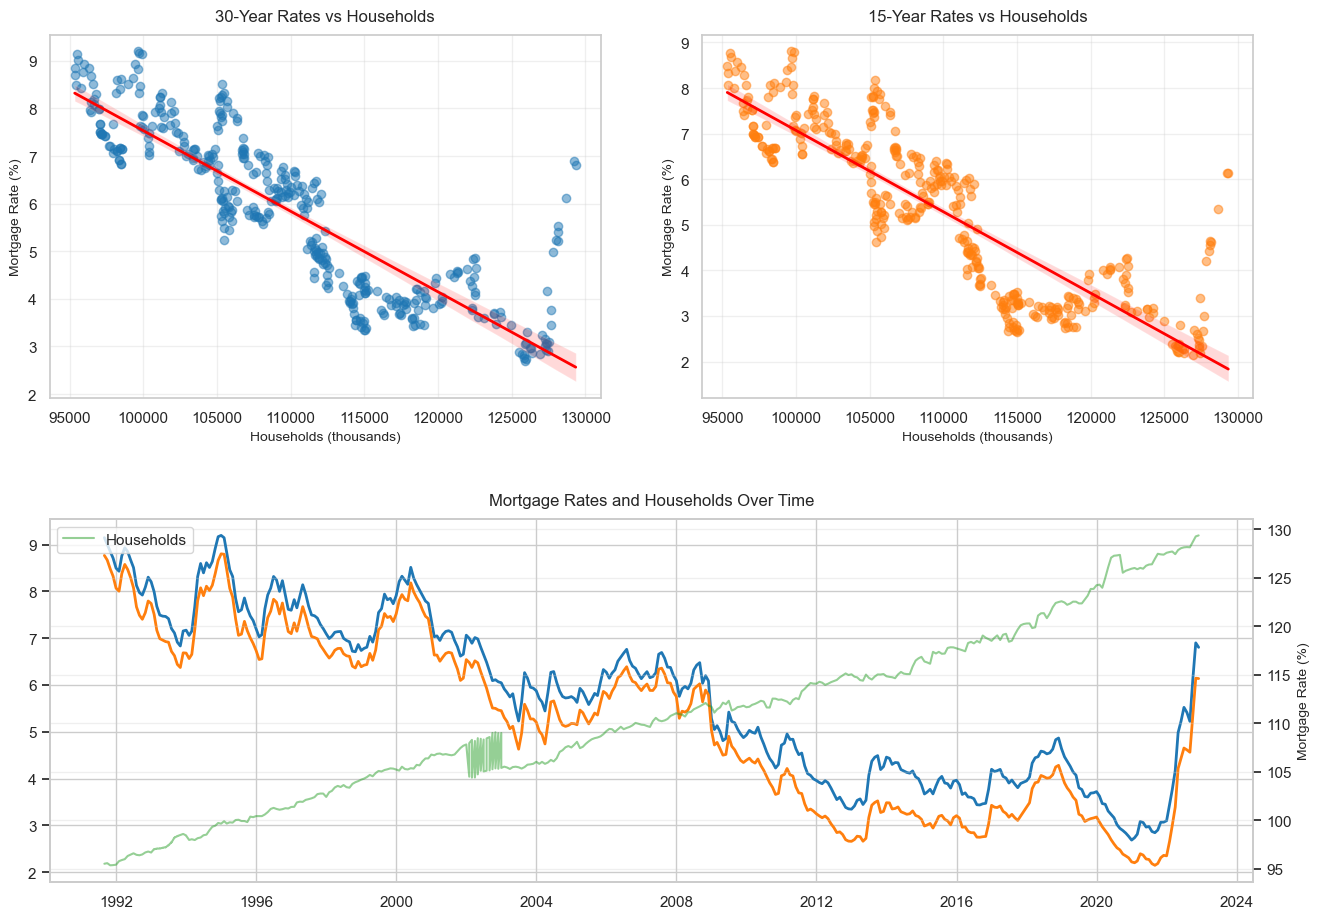

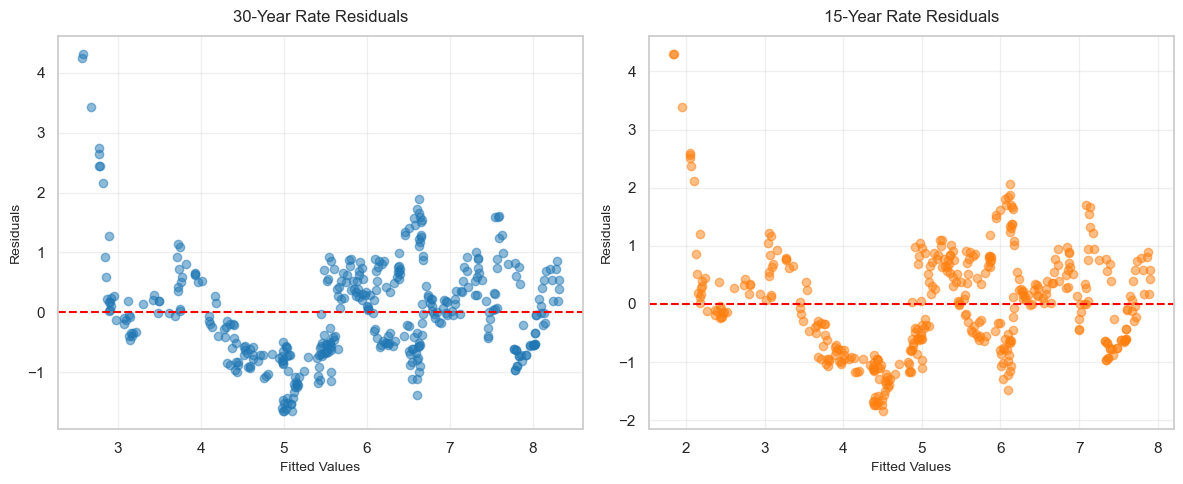

In [126]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the visual style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# 1. Run the regressions
X = sm.add_constant(merged_data['Households'])
model_30yr = sm.OLS(merged_data['30yr_FRM'], X).fit()
model_15yr = sm.OLS(merged_data['15yr_FRM'], X).fit()

# 2. Create the visualization figure
plt.figure(figsize=(14, 10))

# First subplot: 30-year rates vs households
plt.subplot(2, 2, 1)
sns.regplot(x='Households', y='30yr_FRM', data=merged_data,
            scatter_kws={'alpha':0.5, 'color':'#1f77b4'},
            line_kws={'color':'red', 'linewidth':2})
plt.title('30-Year Rates vs Households', fontsize=12, pad=10)
plt.xlabel('Households (thousands)', fontsize=10)
plt.ylabel('Mortgage Rate (%)', fontsize=10)
plt.grid(True, alpha=0.3)

# Second subplot: 15-year rates vs households
plt.subplot(2, 2, 2)
sns.regplot(x='Households', y='15yr_FRM', data=merged_data,
            scatter_kws={'alpha':0.5, 'color':'#ff7f0e'},
            line_kws={'color':'red', 'linewidth':2})
plt.title('15-Year Rates vs Households', fontsize=12, pad=10)
plt.xlabel('Households (thousands)', fontsize=10)
plt.ylabel('Mortgage Rate (%)', fontsize=10)
plt.grid(True, alpha=0.3)

# Third subplot: Time series comparison
plt.subplot(2, 1, 2)
plt.plot(merged_data['Date'], merged_data['30yr_FRM'], 
         label='30-Year Rate', color='#1f77b4', linewidth=2)
plt.plot(merged_data['Date'], merged_data['15yr_FRM'], 
         label='15-Year Rate', color='#ff7f0e', linewidth=2)

# Create a second y-axis for households
ax2 = plt.gca().twinx()
ax2.plot(merged_data['Date'], merged_data['Households']/1000, 
         label='Households', color='#2ca02c', alpha=0.5, linewidth=1.5)
ax2.set_ylabel('Households (thousands)', fontsize=10)

plt.title('Mortgage Rates and Households Over Time', fontsize=12, pad=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Mortgage Rate (%)', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout(pad=3.0)

# 3. Create a separate figure for residual analysis
plt.figure(figsize=(12, 5))

# First residual plot
plt.subplot(1, 2, 1)
plt.scatter(model_30yr.fittedvalues, model_30yr.resid, 
            alpha=0.5, color='#1f77b4')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('30-Year Rate Residuals', fontsize=12, pad=10)
plt.xlabel('Fitted Values', fontsize=10)
plt.ylabel('Residuals', fontsize=10)
plt.grid(True, alpha=0.3)

# Second residual plot
plt.subplot(1, 2, 2)
plt.scatter(model_15yr.fittedvalues, model_15yr.resid, 
            alpha=0.5, color='#ff7f0e')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('15-Year Rate Residuals', fontsize=12, pad=10)
plt.xlabel('Fitted Values', fontsize=10)
plt.ylabel('Residuals', fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [127]:
import pandas as pd

# ===== SEGMENT 1: Load and prepare CPI/Fed Funds data =====
# Load CPI and Fed Funds data
cpi = pd.read_csv("/Users/ianlent/Downloads/CPIAUCSL.csv")
fed = pd.read_csv("/Users/ianlent/Downloads/FEDFUNDS.csv")

# Ensure date columns are datetime
cpi['observation_date'] = pd.to_datetime(cpi['observation_date'])
fed['observation_date'] = pd.to_datetime(fed['observation_date'])

# Rename columns for clarity
cpi.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)
fed.rename(columns={'FEDFUNDS': 'Fed_Funds'}, inplace=True)

# Convert to monthly periods for merging
cpi['Month_Period'] = cpi['observation_date'].dt.to_period('M')
fed['Month_Period'] = fed['observation_date'].dt.to_period('M')

# ===== SEGMENT 2: Housing data merge (as you provided) =====
# Load housing data
df_housing = pd.read_excel(
    "/Users/ianlent/Downloads/histtab13.xlsx",
    skiprows=6,  # Adjust if needed
    header=0
)

# Clean column names
df_housing.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Extract only the numeric part from Year
df_housing['Year'] = df_housing['Year'].astype(str).str.extract(r'(\d+)').astype(float)

# Drop rows where Year is missing
df_housing = df_housing.dropna(subset=['Year'])

# Convert Year to integer
df_housing['Year'] = df_housing['Year'].astype(int)

# Melt and prepare housing data
df_housing = df_housing.melt(
    id_vars=['Year'], 
    var_name='Month', 
    value_name='Households'
)

month_map = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
             'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
df_housing['Month'] = df_housing['Month'].map(month_map)

# Merge with mortgage data
merged_data = pd.merge(
    monthly_rates,
    df_housing,
    on=['Year', 'Month'],
    how='inner'
)

# ===== NEW: Merge with CPI and Fed Funds data =====
# First ensure merged_data has Month_Period column
merged_data['Month_Period'] = pd.to_datetime(merged_data['Date']).dt.to_period('M')

# Merge CPI data
merged_data = pd.merge(
    merged_data,
    cpi[['Month_Period', 'CPI']],
    on='Month_Period',
    how='left'
)

# Merge Fed Funds data
merged_data = pd.merge(
    merged_data,
    fed[['Month_Period', 'Fed_Funds']],
    on='Month_Period',
    how='left'
)

# Calculate YoY inflation rate (CPI % change over 12 months)
merged_data['Inflation'] = merged_data['CPI'].pct_change(periods=12) * 100

# Final cleaning
merged_data = merged_data.dropna()  # Remove any rows with missing values
merged_data = merged_data.sort_values('Date')  # Sort chronologically

# Verify the result
print(merged_data.head())
print("\nColumns in final dataset:", merged_data.columns.tolist())

         Date  30yr_FRM 30yr_Fees  15yr_FRM  15yr_Fees  Year  Month  \
12 1992-08-31    7.9750     1.675     7.490      1.575  1992      8   
13 1992-09-30    7.9225     1.675     7.405      1.600  1992      9   
14 1992-10-31    8.0880       1.8     7.546      1.720  1992     10   
15 1992-11-30    8.3050       1.9     7.795      1.825  1992     11   
16 1992-12-31    8.2060      1.62     7.742      1.600  1992     12   

    Households Month_Period    CPI  Fed_Funds  Inflation  
12     96383.0      1992-08  140.8       3.30   3.074671  
13     96469.0      1992-09  141.1       3.22   2.992701  
14     96674.0      1992-10  141.7       3.10   3.279883  
15     96766.0      1992-11  142.1       3.09   3.120464  
16     96665.0      1992-12  142.3       2.92   2.966715  

Columns in final dataset: ['Date', '30yr_FRM', '30yr_Fees', '15yr_FRM', '15yr_Fees', 'Year', 'Month', 'Households', 'Month_Period', 'CPI', 'Fed_Funds', 'Inflation']


/var/folders/29/pvwc_t8n2b10mnn4g21h9tbr0000gn/T/ipykernel_90615/2684084807.py:81: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged_data['Inflation'] = merged_data['CPI'].pct_change(periods=12) * 100


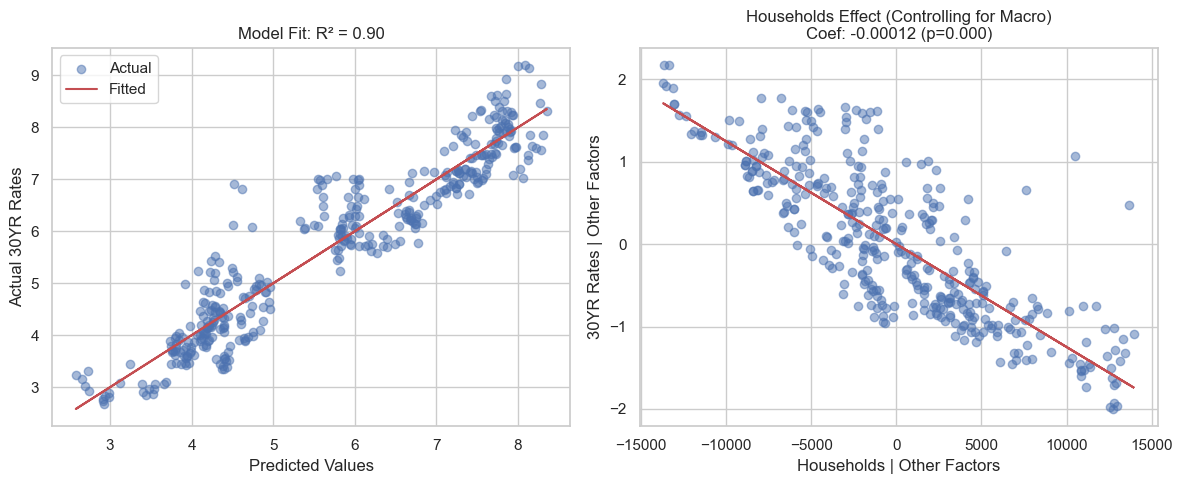

Key Regression Results
Households coefficient: -0.000125
P-value: 0.00000
95% CI: (-0.000134, -0.000116)

Interpretation:
Significant negative relationship (p < 0.05)
Each 10k additional households → -1.248% rate change


In [116]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Filter out rows with NaN in Inflation
regression_data = merged_data.dropna(subset=['Inflation', 'Households', 'Fed_Funds', '30yr_FRM']).copy()

# 2. Regression analysis
X = sm.add_constant(regression_data[['Households', 'Inflation', 'Fed_Funds']])
y = regression_data['30yr_FRM']  

model = sm.OLS(y, X).fit()

# 3. Create compact visualization
plt.figure(figsize=(12, 5))

# Left plot: Actual vs Fitted
plt.subplot(1, 2, 1)
plt.scatter(model.fittedvalues, y, alpha=0.5, label='Actual')
plt.plot(model.fittedvalues, model.fittedvalues, 'r-', label='Fitted')
plt.title('Model Fit: R² = {:.2f}'.format(model.rsquared))
plt.xlabel('Predicted Values')
plt.ylabel('Actual 30YR Rates')
plt.legend()

# Right plot: Households partial relationship
plt.subplot(1, 2, 2)
# Manual partial regression plot
resid_y = sm.OLS(y, sm.add_constant(regression_data[['Inflation', 'Fed_Funds']])).fit().resid
resid_x = sm.OLS(regression_data['Households'], sm.add_constant(regression_data[['Inflation', 'Fed_Funds']])).fit().resid
plt.scatter(resid_x, resid_y, alpha=0.5)
plt.plot(resid_x, sm.OLS(resid_y, resid_x).fit().fittedvalues, 'r-')
plt.title('Households Effect (Controlling for Macro)\nCoef: {:.5f} (p={:.3f})'.format(
    model.params['Households'], model.pvalues['Households']))
plt.xlabel('Households | Other Factors')
plt.ylabel('30YR Rates | Other Factors')

plt.tight_layout()
plt.show()

# 4. Print key results 
print("="*50)
print("Key Regression Results")
print("="*50)
print(f"Households coefficient: {model.params['Households']:.6f}")
print(f"P-value: {model.pvalues['Households']:.5f}")
print(f"95% CI: ({model.conf_int().loc['Households', 0]:.6f}, {model.conf_int().loc['Households', 1]:.6f})")
print("\n" + "="*50)
print("Interpretation:")
if model.pvalues['Households'] < 0.05:
    direction = "negative" if model.params['Households'] < 0 else "positive"
    print(f"Significant {direction} relationship (p < 0.05)")
    print(f"Each 10k additional households → {model.params['Households']*10000:.3f}% rate change")
else:
    print("No significant relationship found (p ≥ 0.05)")

**Hypothesis:**
Null Hypothesis ($H_0$): $\beta_{\text{Households}} = 0$
(No effect of the number of households on the mortgage rate.)

Alternative Hypothesis ($H_1$): $\beta_{\text{Households}} \ne 0$
(A statistically significant effect exists.)

**Key Assumptions (OLS):**
Linearity: The relationship between $X$ and $Y$ is linear.

Independence: Observations are independent.

Normality: Errors are normally distributed.

**Model Specification:**
$$
\text{30yr\_FRM}_t = \beta_0 + \beta_1 \cdot \text{Households}_t + \beta_2 \cdot \text{Inflation}_t + \beta_3 \cdot \text{Fed\_Funds}_t + \varepsilon_t
$$

    
$\beta_{\text{Households}} = -0.000125$

p-value = 0.00000

95% CI = (-0.000134, -0.000116)

$R^2 \approx$ insert actual value from model.rsquared


**Interpretation:**
The negative coefficient implies that as the number of households increases, mortgage rates tend to decrease.

The p-value < 0.001 confirms this relationship is statistically significant.

**Effect size interpretation:**
For every 10,000 additional households:
there is a -1.25% reduction in the 30yr_FRM shown by the right panel plot


This relationship is visualized in the partial regression plot (right panel), showing the residual 
effect of Households after controlling for inflation and the Fed Funds rat

**Visualization References:**
Left plot: Predicted vs. actual mortgage rates confirms overall model fit (linear trend with $R^2$ label).
Right plot: Residual plot isolates the effect of Households (partial regression).


**CONCLUSIONS:**
The number of U.S. households is a statistically significant and economically 
meaningful predictor of the 30-year fixed mortgage rate. This suggests that 
housing demand dynamics, proxied by household formation, may influence long-term borrowing 
costs—independent of macroeconomic policy variables like inflation or the federal funds rate.

### Partial Regression Specification (Controlling for Macro Factors)

To isolate the effect of household formation on mortgage rates while controlling for macroeconomic variables, we use a partial regression framework:

#### Step 1: Residualize Both Variables

We first remove the influence of inflation and the federal funds rate from both the dependent and independent variables:

- Regress 30-year mortgage rates on inflation and Fed funds rate:
  
  $$
  \text{30yr\_FRM}_t = \alpha_0 + \alpha_1 \cdot \text{Inflation}_t + \alpha_2 \cdot \text{FedFunds}_t + u_t
  $$
  
  → Collect residuals \( \hat{u}_t \), the component of mortgage rates unexplained by macro factors.

- Regress Household formation on inflation and Fed funds rate:
  
  $$
  \text{Households}_t = \gamma_0 + \gamma_1 \cdot \text{Inflation}_t + \gamma_2 \cdot \text{FedFunds}_t + v_t
  $$
  
  → Collect residuals \( \hat{v}_t \), the component of household growth unexplained by macro factors.

#### Step 2: Partial Regression

Then regress the residuals:

$$
\hat{u}_t = \delta_0 + \delta_1 \cdot \hat{v}_t + \varepsilon_t
$$

This yields \( \delta_1 \), the **partial effect of household formation** on mortgage rates after removing shared variance with macroeconomic variables.

#### Interpretation

This approach visually and statistically quantifies the *independent* effect of household formation, net of macroeconomic influences, and is visualized using a partial regression (added-variable) plot.

                     